In [1]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn import metrics


import warnings
warnings.filterwarnings("ignore")

/home/anson/.local/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Loading Data

In [2]:
cm = 3

mN = 1
# mN = 2
# mN = 0.2

# V2 = 1e-5
V2 = 1e-6

if mN == 1:
#     Old: BDT cut: 0.3, mN cut:[mN*0.9, mN*1.1]
#     modes_dt = {1: {'mode': f'../features/signal_tchannel_reco_E-{cm}TeV_N-{mN}TeV.root', 'yields': 1.17e7*V2},
#                 2: {'mode': f'../features/signal_schannel_reco_E-{cm}TeV_N-{mN}TeV.root', 'yields': 1.75e3*V2}, 
#                 3: {'mode': f'../features/signal_tchannel_reco_E-{cm}TeV_N-{mN}TeV_Dirac.root', 'yields': 1.22e7*V2},
#                 4: {'mode': f'../features/signal_schannel_reco_E-{cm}TeV_N-{mN}TeV_Dirac.root', 'yields': 1.77e3*V2},
#                 0: {'mode': f'../features/background_reco_E-{cm}TeV.root', 'yields': 1.88e5}
#                }
#     New: BDT cut: 0.3, mN cut:[mN*0.95, mN*1.025]
    modes_dt = {1: {'mode': f'../features/signal_tchannel_reco_E-{cm}TeV_N-{mN}TeV.root', 'yields': 1.21e7*V2},
                2: {'mode': f'../features/signal_schannel_reco_E-{cm}TeV_N-{mN}TeV.root', 'yields': 1.87e3*V2}, 
                3: {'mode': f'../features/signal_tchannel_reco_E-{cm}TeV_N-{mN}TeV_Dirac.root', 'yields': 1.26e7*V2},
                4: {'mode': f'../features/signal_schannel_reco_E-{cm}TeV_N-{mN}TeV_Dirac.root', 'yields': 1.88e3*V2},
                0: {'mode': f'../features/background_reco_E-{cm}TeV.root', 'yields': 1.99e5}
               }
elif mN == 2:
#     modes_dt = {1: {'mode': f'../features/signal_tchannel_reco_E-{cm}TeV_N-{mN}TeV.root', 'yields': 8.06e6*V2},
#                 2: {'mode': f'../features/signal_schannel_reco_E-{cm}TeV_N-{mN}TeV.root', 'yields': 8.36e2*V2}, 
#                 3: {'mode': f'../features/signal_tchannel_reco_E-{cm}TeV_N-{mN}TeV_Dirac.root', 'yields': 8.26e6*V2},
#                 4: {'mode': f'../features/signal_schannel_reco_E-{cm}TeV_N-{mN}TeV_Dirac.root', 'yields': 8.58e2*V2},
#                 0: {'mode': f'../features/background_reco_E-{cm}TeV.root', 'yields': 1.84e5}
#                }
    modes_dt = {1: {'mode': f'../features/signal_tchannel_reco_E-{cm}TeV_N-{mN}TeV.root', 'yields': 8.49e6*V2},
                2: {'mode': f'../features/signal_schannel_reco_E-{cm}TeV_N-{mN}TeV.root', 'yields': 8.79e2*V2}, 
                3: {'mode': f'../features/signal_tchannel_reco_E-{cm}TeV_N-{mN}TeV_Dirac.root', 'yields': 8.69e6*V2},
                4: {'mode': f'../features/signal_schannel_reco_E-{cm}TeV_N-{mN}TeV_Dirac.root', 'yields': 8.91e2*V2},
                0: {'mode': f'../features/background_reco_E-{cm}TeV.root', 'yields': 1.99e5}
               }
elif mN == 0.2:
    modes_dt = {1: {'mode': f'../features/signal_tchannel_reco_E-{cm}TeV_N-02TeV.root', 'yields': 5.13e5*V2},
                2: {'mode': f'../features/signal_schannel_reco_E-{cm}TeV_N-02TeV.root', 'yields': 2.18e3*V2}, 
                3: {'mode': f'../features/signal_tchannel_reco_E-{cm}TeV_N-02TeV_Dirac.root', 'yields': 5.16e5*V2},
                4: {'mode': f'../features/signal_schannel_reco_E-{cm}TeV_N-02TeV_Dirac.root', 'yields': 2.33e3*V2},
                0: {'mode': f'../features/background_reco_E-{cm}TeV.root', 'yields': 1.99e5}
               }

In [3]:
def load_train_test(modes_dt, size=0.5):
    np.random.seed(9)
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    num_lt = []
    
    # loop over different modes
    for i, (k, v) in enumerate(modes_dt.items()):
        file = uproot.open(v['mode'])
        df_i = pd.DataFrame(np.array(file['t']['features'].array()))
        df_i['target'] = k    # add the target label
        df_i['weight'] = v['yields']/len(df_i)
#         print(k, v)
        num_lt.append(len(df_i))

        # shuffle the index for training and testing sets
        idx = df_i.index.tolist()
        np.random.shuffle(idx)
        
        # cut according to the fraction
        cut = int(np.ceil(len(idx) * size))
        df_train_i = df_i.loc[idx[:cut]]
        df_test_i = df_i.loc[idx[cut:]]
        
        # Put to the global dataframs
        df_train = pd.concat([df_train, df_train_i])
        df_test = pd.concat([df_test, df_test_i])
    
    df_train.reset_index(drop=True, inplace=True)
    df_test.reset_index(drop=True, inplace=True)
    
    print('train size: {} ({:.2f}%); test size: {} ({:.2f}%)'.format(len(df_train), 100*len(df_train)/(len(df_train)+len(df_test)), len(df_test), 100*len(df_test)/(len(df_train)+len(df_test))))
    print('data points per mode: ',num_lt)
    return df_train, df_test

    

In [4]:
tr_te_size = 0.5 
df_train, df_test = load_train_test(modes_dt, tr_te_size)


df_train_o, df_test_o = df_train.copy(), df_test.copy()

train size: 17857 (50.00%); test size: 17855 (50.00%)
data points per mode:  [5707, 6138, 5861, 6098, 11908]


### Prepare for BDT

In [5]:
def relabel(x):
    if x == 0 :    # bkg
        return 0
    elif x == 1:     # s-channel signal
        return 1
    elif x == 2:    # t-channel signal
        return 1
    elif x == 3:     # s-channel signal
        return 1
    elif x == 4:    # t-channel signal
        return 1

In [6]:
# features = ['ptLep', 'etaLep', 'ELep', 'chargeLep', # lepton info
#             'DeltaPhijjl', 'DeltaRjjl',             # Delta phi & Delta R between jj(from W boson) and lepton
#             'ptJJ', 'etaJJ', 'mJJ',                 # jj(from W boson) momentum info
#             'mN', 'ptN', 'pzN'                      # reconstructed N 4 momentum info
#            ]

features = ['ptLep', 'etaLep', 'ELep', 'chargeLep', # lepton info
            'DeltaPhijjl', 'DeltaRjjl',             # Delta phi & Delta R between jj(from W boson) and lepton
            'ptJJ', 'etaJJ', 'mJJ',                 # jj(from W boson) momentum info
            'ptN', 'pzN'                            # reconstructed N 4 momentum info
           ]

# features = ['ptLep', 'etaLep', 'ELep', 'chargeLep', # lepton info
#             'DeltaPhijjl', 'DeltaRjjl',             # Delta phi & Delta R between jj(from W boson) and lepton
#             'ptJJ', 'etaJJ', 'mJJ',                 # jj(from W boson) momentum info
#             'ptN', 'pzN',                      # reconstructed N 4 momentum info
#             'EJet1', 'EJet2'
#            ]

# features = ['ptLep', 'etaLep', 'ELep', 'chargeLep', # lepton info
#             'DeltaPhijjl', 'DeltaRjjl',             # Delta phi & Delta R between jj(from W boson) and lepton
#             'ptJJ', 'etaJJ', 'mJJ',                 # jj(from W boson) momentum info
#             'ptN', 'pzN',                      # reconstructed N 4 momentum info
#             'pTheta'
#            ]


In [7]:
# relabel the, all bkg become one label
df_train['target'] = df_train['target'].apply(relabel)
df_test['target'] = df_test['target'].apply(relabel)

In [8]:
# getting the inputs and labels
X_train = df_train[features]
y_train = np.array(df_train.target)

# getting the inputs and labels
X_test = df_test[features]
y_test = np.array(df_train.target)

In [9]:
# trainging
X_train = df_train[features]
y_train = np.array([relabel(i) for i in df_train['target']])

# testing
X_test = df_test[features]
y_test = np.array([relabel(i) for i in df_test['target']])

# fitting, with reweighting
xgbc1 = xgb.XGBClassifier(seed=0)
xgbc1.fit(X_train, y_train, sample_weight=df_train.weight.values);
# xgbc1.fit(X_train, y_train);

In [10]:
# transform the BDT output to score
# def soft(prob, target):
#     return np.exp(prob[:, target])/(np.exp(prob).sum(axis=1)) 

# scores for training
df_bdt_train_s = df_train[['target', 'weight']]
df_bdt_train_s.loc[:, 'pred1'] = xgbc1.predict_proba(X_train)[:, 1]

# score for testing 
df_bdt_test_s = df_test[['target', 'weight']]
df_bdt_test_s.loc[:, 'pred1'] = xgbc1.predict_proba(X_test)[:, 1]


# # scores for training
# df_bdt_train_s = df_train[['target', 'weight']]
# df_bdt_train_s.loc[:, 'pred1'] = xgbc1.predict_proba(X_train)[:, 1]

# # score for testing 
# df_bdt_test_s = df_test[['target', 'weight']]
# df_bdt_test_s.loc[:, 'pred1'] = xgbc1.predict_proba(X_test)[:, 1]

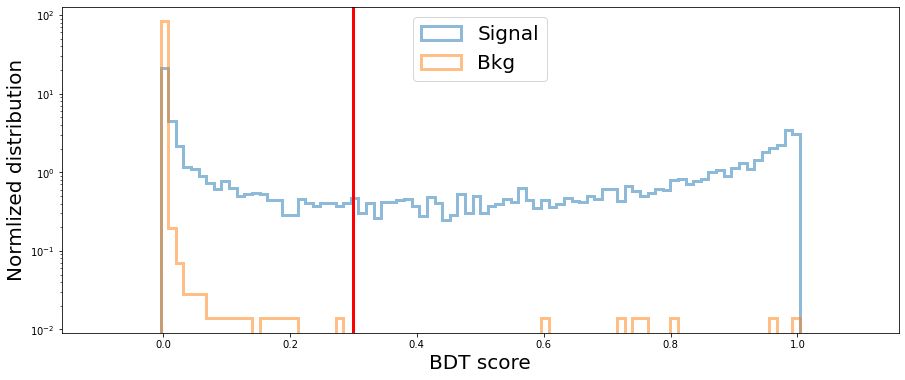

In [11]:
# BDT score distribution 

# f = plt.figure(figsize=(8,6))
f = plt.figure(figsize=(15,6))
ax1 = plt.subplot(111)

df_plot = df_bdt_test_s
# df_plot = df_bdt_train_s

pred0_max = df_plot[(df_plot.target==1)]['pred1'].max() 
pred0_min = df_plot[(df_plot.target==1)]['pred1'].min() 
pred0_diff = pred0_max - pred0_min
range_=[pred0_min - 0.1*pred0_max, pred0_max + 0.1*pred0_diff]

bins_=100

ax1.hist(df_plot[(df_plot.target==1)]['pred1'], weights=df_plot[df_plot.target==1]['weight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'Signal', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==0)]['pred1'], weights=df_plot[df_plot.target==0]['weight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'Bkg', alpha=0.5);

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'BDT score', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=9, fontsize=20)

ax1.set_yscale('log')

# threshold = 0.4
threshold = 0.3
# threshold = 0.275

ax1.axvline(threshold, color='red', lw=3)


# =================================================================================
# Apply BDT score cut
df_bdt_cut = df_bdt_test_s[(df_bdt_test_s['pred1'] >= threshold)]
# =================================================================================



In [12]:

df_bdt_cut['target'] = df_test_o.loc[df_bdt_cut.index]['target']
df_bdt_cut['iEvt'] = df_test_o.loc[df_bdt_cut.index]['iEvt']
df_bdt_cut0 = df_bdt_cut[(df_bdt_cut['target'] == 0)]
df_bdt_cut1 = df_bdt_cut[(df_bdt_cut['target'] == 1)]
df_bdt_cut2 = df_bdt_cut[(df_bdt_cut['target'] == 2)]
df_bdt_cut3 = df_bdt_cut[(df_bdt_cut['target'] == 3)]
df_bdt_cut4 = df_bdt_cut[(df_bdt_cut['target'] == 4)]

df_bdt_cut0['mN'] = df_test_o.loc[df_bdt_cut0.index]['mN']
df_bdt_cut1['mN'] = df_test_o.loc[df_bdt_cut1.index]['mN']
df_bdt_cut2['mN'] = df_test_o.loc[df_bdt_cut2.index]['mN']
df_bdt_cut3['mN'] = df_test_o.loc[df_bdt_cut3.index]['mN']
df_bdt_cut4['mN'] = df_test_o.loc[df_bdt_cut4.index]['mN']


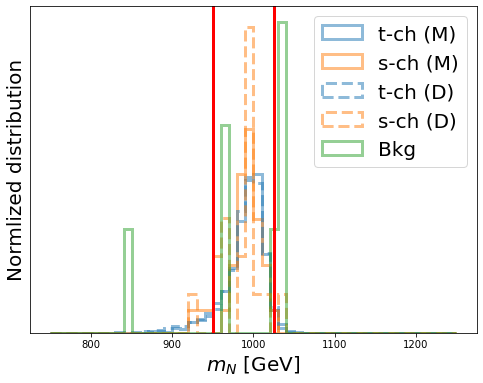

In [13]:
# mN distribution after BDT cut

f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)

range_ = [mN*(1-0.25)*1000, mN*(1+0.25)*1000]

col = 'm'
particle = 'N'

bins_=50
ax1.hist(df_bdt_cut1[col+particle], weights=[1/len(df_bdt_cut1)]*len(df_bdt_cut1), bins=bins_, range=range_, histtype='step', alpha=0.5, lw=3, label='t-ch (M)', color='C0');
ax1.hist(df_bdt_cut2[col+particle], weights=[1/len(df_bdt_cut2)]*len(df_bdt_cut2), bins=bins_, range=range_, histtype='step', alpha=0.5, lw=3, label='s-ch (M)', color='C1');
ax1.hist(df_bdt_cut3[col+particle], weights=[1/len(df_bdt_cut3)]*len(df_bdt_cut3), bins=bins_, range=range_, histtype='step', alpha=0.5, lw=3, label='t-ch (D)', color='C0', linestyle='--');
ax1.hist(df_bdt_cut4[col+particle], weights=[1/len(df_bdt_cut4)]*len(df_bdt_cut4), bins=bins_, range=range_, histtype='step', alpha=0.5, lw=3, label='s-ch (D)', color='C1', linestyle='--');
ax1.hist(df_bdt_cut0[col+particle], weights=[1/len(df_bdt_cut0)]*len(df_bdt_cut0), bins=bins_, range=range_, histtype='step', alpha=0.5, lw=3, label='Bkg', color='C2');


ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$m_N ~[\rmGeV]$', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)


# partition_u = 0.05
partition_u = 0.025
# partition_u = 0.1
# partition_l = 0.1
partition_l = 0.05
ax1.axvline(1000*mN*(1-partition_l), color='red', lw=3)
ax1.axvline(1000*mN*(1+partition_u), color='red', lw=3)

# f.savefig('./figures/mN')


# =========================================================================================
# manully apply cut on mN
df_bdt_cut['mN'] = df_test_o.loc[df_bdt_cut.index]['mN']
df_bdt_cut = df_bdt_cut[(df_bdt_cut.mN>=1000*mN*(1-partition_l)) & (df_bdt_cut.mN<=1000*mN*(1+partition_u))]
# df_bdt_cut = df_bdt_cut[(df_bdt_cut.mN>=1800) & (df_bdt_cut.mN<=2200)]
# =========================================================================================



In [14]:
df_bdt_cut0 = df_bdt_cut[(df_bdt_cut['target'] == 0)]   # Bkg
df_bdt_cut1 = df_bdt_cut[(df_bdt_cut['target'] == 1)]   # t-ch M
df_bdt_cut2 = df_bdt_cut[(df_bdt_cut['target'] == 2)]   # s-ch M
df_bdt_cut3 = df_bdt_cut[(df_bdt_cut['target'] == 3)]   # t-ch D
df_bdt_cut4 = df_bdt_cut[(df_bdt_cut['target'] == 4)]   # s-ch D

# yield (without |V|^2 dependence)
nb = df_bdt_cut0.weight.sum() / tr_te_size          # Bkg
ntM = df_bdt_cut1.weight.sum() / tr_te_size / V2    # t-ch M
nsM = df_bdt_cut2.weight.sum() / tr_te_size / V2    # s-ch M
ntD = df_bdt_cut3.weight.sum() / tr_te_size / V2    # t-ch D
nsD = df_bdt_cut4.weight.sum() / tr_te_size / V2    # s-ch D

nM = nsM + ntM    # total M
nD = nsD + ntD    # total D

print('yields: ')
print(f'Bkg:\t{nb:.2e}')
print(f'(M):\t{nM:.2e}')
print(f'(D):\t{nD:.2e}')
print(f'  t-ch (M):\t{ntM:.2e}')
print(f'  s-ch (M):\t{nsM:.2e}')
print(f'  t-ch (D):\t{ntD:.2e}')
print(f'  s-ch (D):\t{nsD:.2e}')

yields: 
Bkg:	1.00e+02
(M):	5.88e+06
(D):	5.53e+06
  t-ch (M):	5.88e+06
  s-ch (M):	1.77e+01
  t-ch (D):	5.53e+06
  s-ch (D):	1.05e+01


In [15]:
N = 1.96
M = N**2

print('Fully Majorana case:')
upperM, lowerM = ((M+(M**2 + 4*M*nb)**0.5)/2)/(nM), ((M-(M**2 + 4*M*nb)**0.5)/2)/(nM)
print(f"upper limit on |V|^2: {upperM:.2e}")
print(f"lower limit on |V|^2: {lowerM:.2e}")
print()

print('Fully Dirac case:')
upperD, lowerD = ((M+(M**2 + 4*M*nb)**0.5)/2)/(nD), ((M-(M**2 + 4*M*nb)**0.5)/2)/(nD)
print(f"upper limit on |V|^2: {upperD:.2e}")
print(f"lower limit on |V|^2: {lowerD:.2e}")

Fully Majorana case:
upper limit on |V|^2: 3.68e-06
lower limit on |V|^2: -3.03e-06

Fully Dirac case:
upper limit on |V|^2: 3.91e-06
lower limit on |V|^2: -3.22e-06


In [16]:
eff0, eff1, eff2, eff3, eff4 = \
len(df_bdt_cut0) / len(df_test_o[df_test_o.target==0]), \
len(df_bdt_cut1) / len(df_test_o[df_test_o.target==1]), \
len(df_bdt_cut2) / len(df_test_o[df_test_o.target==2]), \
len(df_bdt_cut3) / len(df_test_o[df_test_o.target==3]), \
len(df_bdt_cut4) / len(df_test_o[df_test_o.target==4])

print("BDT eff:")
print("bkg:\t\t{:2f}%".format(100*eff0))
print("t-ch (M):\t{:2f}%".format(100*eff1))
# print("s-ch (M):\t{:2f}%".format(100*eff2))
print("t-ch (D):\t{:2f}%".format(100*eff3))
# print("s-ch (D):\t{:2f}%".format(100*eff4))

BDT eff:
bkg:		0.050386%
t-ch (M):	48.615492%
t-ch (D):	43.890785%


In [17]:
print("s/b ratio: ")
print(f'# Maj signal / bkg = {nM/nb:.0f} x |V|^2')
print(f'# Dir signal / bkg = {nD/nb:.0f} x |V|^2')

s/b ratio: 
# Maj signal / bkg = 58657 x |V|^2
# Dir signal / bkg = 55145 x |V|^2


In [18]:
print("s/sqrt(b) ratio: ")
print(f'# Maj signal / sqrt(bkg) = {nM/(nb)**0.5:.0f} x |V|^2')
print(f'# Dir signal / sqrt(bkg) = {nD/(nb)**0.5:.0f} x |V|^2')

s/sqrt(b) ratio: 
# Maj signal / sqrt(bkg) = 587357 x |V|^2
# Dir signal / sqrt(bkg) = 552189 x |V|^2


In [19]:
d = xgbc1.get_booster().get_score()
dict(sorted(d.items(), key=lambda item: -1*item[1]))

{'pzN': 115.0,
 'ELep': 62.0,
 'ptLep': 61.0,
 'ptJJ': 61.0,
 'etaLep': 57.0,
 'DeltaRjjl': 44.0,
 'ptN': 32.0,
 'etaJJ': 31.0,
 'DeltaPhijjl': 25.0,
 'mJJ': 22.0,
 'chargeLep': 1.0}

In [40]:
# df_test_o = df_test_o.set_index('iEvt')

In [180]:
for t in range(5):
    df_bdt_cut.loc[df_bdt_cut.target==t, ['pxLep', 'pyLep', 'pzLep', 'pxN', 'pyN', 'pzN']] = \
    df_test_o[(df_test_o.target==t)].loc[df_bdt_cut[df_bdt_cut.target==t].iEvt][['pxLep', 'pyLep', 'pzLep', 'pxN', 'pyN', 'pzN']].values

In [181]:
# df = df_tD_o
df = df_bdt_cut

pp = np.array([0,0,1])

Nk = []
Nr = []
Nn = []

# for i in range(len(df)):
# for i in range(10):
# k = np.array([df.iloc[i]['pxN'], df.iloc[i]['pyN'], df.iloc[i]['pzN']])
k = np.array(df[['pzN', 'pyN', 'pzN']])
k = k / (np.sum(k**2, axis=1) ** 0.5).reshape(-1,1)

yp = np.dot(k, pp)
rp = (1-yp**2)**0.5
r = np.sign(yp).reshape(-1,1) * (pp-k*yp.reshape(-1,1)) / rp.reshape(-1,1)
    
n = np.cross(k, r)
    
vLep = df[['pxLep', 'pyLep', 'pzLep']]
    
df['Nk'] = np.diag(np.dot(k, vLep.T)) / np.diag(np.dot(vLep, vLep.T)) * np.diag(np.dot(k, k.T))
df['Nr'] = np.diag(np.dot(r, vLep.T)) / np.diag(np.dot(vLep, vLep.T)) * np.diag(np.dot(r, r.T))
df['Nn'] = np.diag(np.dot(n, vLep.T)) / np.diag(np.dot(vLep, vLep.T)) * np.diag(np.dot(n, n.T))

In [195]:
Nk_pos_s = df[(df.Nk>0) & (df.target!=0)].weight.sum() / tr_te_size 
Nk_pos_b = df[(df.Nk>0) & (df.target==0)].weight.sum() / tr_te_size

Nk_neg_s = df[(df.Nk<0) & (df.target!=0)].weight.sum() / tr_te_size 
Nk_neg_b = df[(df.Nk<0) & (df.target==0)].weight.sum() / tr_te_size 

In [196]:
(1/(Nk_pos_s/(Nk_pos_s+Nk_pos_b)**0.5) + 1/(Nk_neg_s/(Nk_neg_s+Nk_neg_b)**0.5))**0.5

1.4288615976941144

In [197]:
Nk_pos_s, Nk_pos_b

(10.482035201965019, 100.26872690628149)

In [198]:
Nk_neg_s, Nk_neg_b

(0.9287321334001024, 0.0)